In [11]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/hp/Desktop/Aptech/My SQL + Python ( E-Commerce)'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = db.cursor()

# 1.List all unique cities where customers are located.

In [101]:
query = """select distinct customer_city from customers"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [31]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cursor.execute(query)
data = cursor.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# 3. Find the total sales per category.

In [62]:
import pandas as pd
query = """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""
cursor.execute(query)
data = cursor.fetchall()
#data
df = pd.DataFrame(data, columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [80]:
query = """select sum(case when payment_installments >= 1 then 1
else 0 end) from payments"""
cursor.execute(query)
data = cursor.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('103884'))

# 5.Count the number of customers from each state.

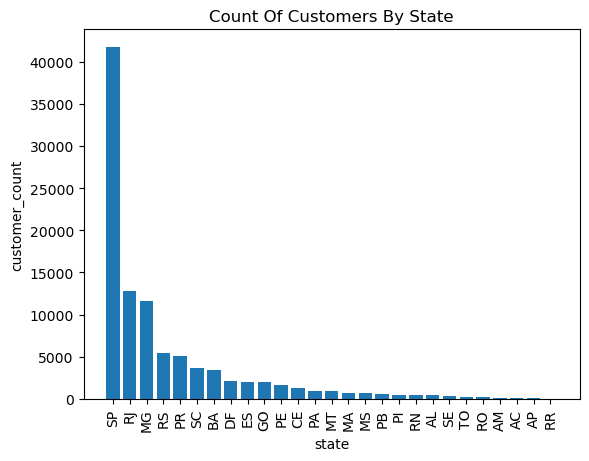

In [122]:
query = """select customer_state, count(customer_id)
from customers 
group by customer_state"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("state")
plt.ylabel("customer_count")
plt.title("Count Of Customers By State")
plt.show()
# df



# 6.Calculate the number of orders per month in 2018.

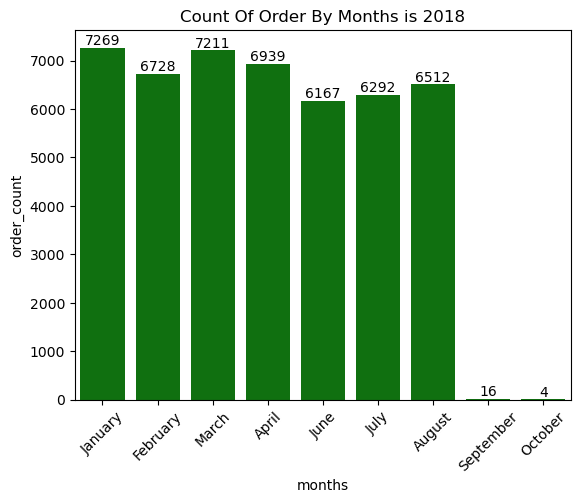

In [128]:
query = """select monthname(order_purchase_timestamp)months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "June", "July", "August", "September", "October"]

fx = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, color = "green")
plt.xticks(rotation = 45)
fx.bar_label(fx.containers[0])
plt.title("Count Of Order By Months is 2018")
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [155]:
query = """with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["customer_city","average orders"])
df.head(10)

,customer_city,average orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [163]:
query = """select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc;"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["category", "sales_percentage"])
df.head(10)

,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [188]:
import numpy as np
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products
join order_items on products.product_id = order_items.product_id
group by products.product_category"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][-1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

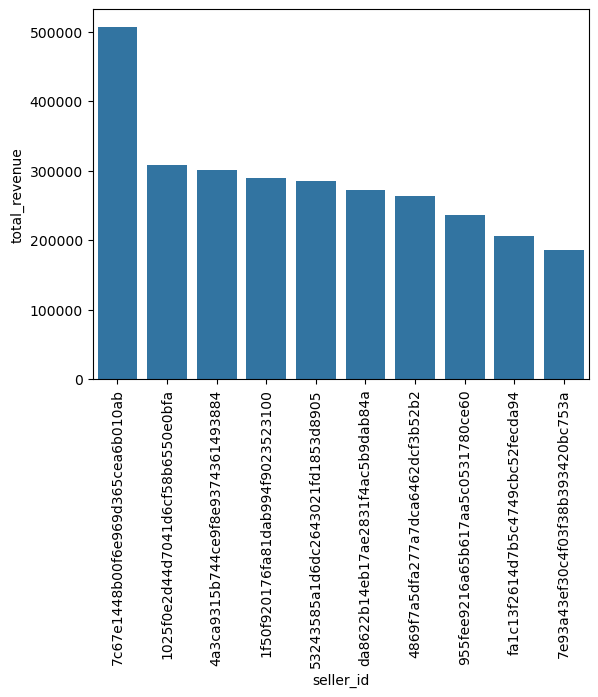

In [288]:
query = """select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by  order_items.seller_id) as a """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "total_revenue", "Rank"])
df = df.head(10)
sns.barplot(x = "seller_id", y = "total_revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

In [222]:
query = """select customer_id, order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "mov_avg"])
df 

,customer_id,order_purchase_timestamp,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000


# 12. Calculate the cumulative sales per month for each year.

In [251]:
query = """select years, months,payment,sum(payment)
over(order by years, months) cummulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["years", "months", "payments","cummulative_sum"])
df 

,years,months,payments,cummulative_sum
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# 13. Calculate the year-over-year growth rate of total sales.

In [258]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment-lag(payment,1) over(order by years))/ lag(payment,1) over(order by years))*100 from a
"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["years", "YOY% Growth"])
df 

,years,YOY% Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [263]:
query = """with a as(select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by  customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""
cursor.execute(query)
data = cursor.fetchall()
data
# None of the customer is repeated that's why the value if Null.

[(None,)]

# 15. Identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

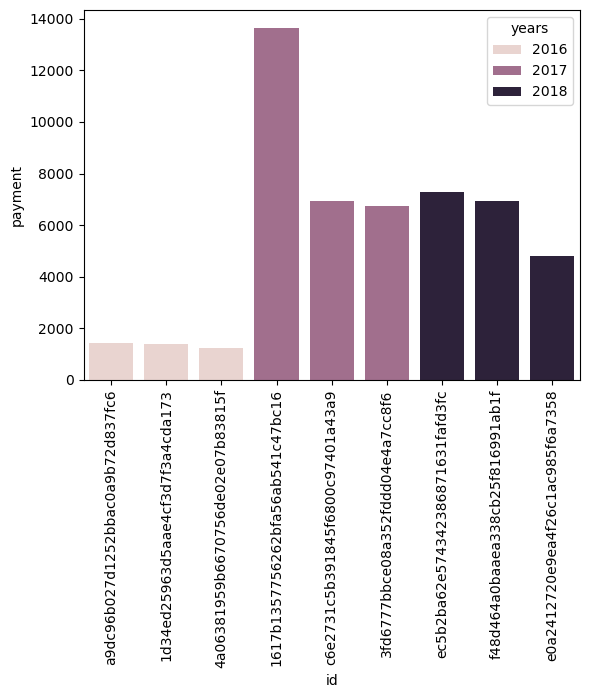

In [286]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years, orders.customer_id, 
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <= 3
"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["years", "id","payment", "rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)